In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
tqdm.pandas()


pd.set_option('display.max_columns', 50)

In [3]:
with open('Full_Dataset.pkl', 'rb') as file:
    data = pickle.load(file)

C:\Users\thiba\AppData\Local\Temp\ipykernel_13688\2797961124.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(file)


In [4]:
col2drop = ['isin', 'wkn', 'name', 'fundProvider', 'legalStructure', 'fundCurrency',
            'inceptionDate', 'ticker', 'domicileCountry', 'labels', 'Ticker_Info', 'Holdings',
            'holdings_symbols', 'holdings_names', 'holdings_percents', 'Stock_Data']

df = data.drop(columns=col2drop)
df.head()
df['quote'] = df['quote'].astype(float)

df = df.fillna(df.mean())
df.head()

,quote,ter,maxAge,cashPosition,stockPosition,bondPosition,otherPosition,preferredPosition,convertiblePosition,priceToEarnings,priceToBook,priceToSales,priceToCashflow,sector_realestate,sector_consumer_cyclical,sector_basic_materials,sector_consumer_defensive,sector_technology,sector_communication_services,sector_financial_services,sector_utilities,sector_industrials,sector_energy,sector_healthcare,Var,drawdown,avg_sharpe_ratio,beta,avg_monthly_return,volatility,RSI
0,6.68,0.0030,1,0.0042,0.9957,0.0,0.0,0.0,0.0,0.06184,0.45693,0.63720,0.09668,0.000000,0.000000,0.05850,0.227400,0.18890,0.100300,0.098100,0.000000,0.151900,0.153400,0.021400,-0.012182,-0.224168,-0.943643,0.0,0.016163,0.009947,53.540314
1,72.34,0.0030,1,0.0026,0.9974,0.0,0.0,0.0,0.0,0.06185,0.45699,0.63723,0.09669,0.000000,0.000000,0.05860,0.227400,0.18870,0.100300,0.098100,0.000000,0.152000,0.153500,0.021400,-0.011809,-0.356065,-0.803378,0.0,0.013677,0.010545,53.611734
2,10.70,0.0040,1,0.0000,0.0000,0.0,1.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.079179,0.096948,0.05762,0.063838,0.17264,0.060456,0.168675,0.039496,0.113065,0.041108,0.096776,-0.013404,-0.200601,-0.647148,0.0,0.030004,0.013205,65.807441
3,92.64,0.0035,1,-0.0288,1.0288,0.0,0.0,0.0,0.0,0.06283,0.79478,0.98876,0.12598,0.141400,0.059100,0.08280,0.054400,0.02380,0.000000,0.095700,0.000000,0.347500,0.144300,0.051100,-0.013861,-0.423651,-0.784502,0.0,0.005198,0.011083,46.335950
4,34.38,0.0032,1,0.0356,0.9644,0.0,0.0,0.0,0.0,0.11598,1.10211,1.36811,0.27793,0.031500,0.028400,0.10990,0.000000,0.00920,0.020300,0.416300,0.130400,0.122600,0.131300,0.000000,-0.014308,-0.484438,-0.656542,0.0,0.010611,0.012936,46.086928


# Using only labels

In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

model_name = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)


def get_embedding(text):
    # Tokenize and get model outputs
    inputs = tokenizer(text, return_tensors='pt', padding=False, truncation=True, max_length=50)
    with torch.no_grad():
        outputs = model(**inputs)
    # Pooling - take the mean of token embeddings
    last_hidden_state = outputs.hidden_states[-1]
    embeddings = last_hidden_state.mean(dim=1)
    embeddings = embeddings.detach().numpy()
    return pd.Series(embeddings.flatten())


embedding_df = data['labels'].progress_apply(get_embedding)

embedding_df

  0%|          | 0/1021 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-1.673864,0.838149,-0.754202,0.267050,1.236107,-0.578612,0.608196,0.306956,0.191781,0.798780,0.090404,-0.298926,0.338857,-0.992628,0.732582,1.487651,0.001934,1.036421,0.669500,-1.233144,-0.408093,-0.020149,0.122060,1.575999,0.225101,...,0.081083,-0.515445,0.767569,-0.430170,0.335472,0.473285,-0.179121,-0.193246,-0.775121,0.972723,-1.271221,-0.535102,0.636216,0.127388,-0.800563,1.107801,-0.272077,0.244048,0.963031,0.009197,0.289280,0.006288,0.303251,0.512392,0.205169
1,-1.673864,0.838149,-0.754202,0.267050,1.236107,-0.578612,0.608196,0.306956,0.191781,0.798780,0.090404,-0.298926,0.338857,-0.992628,0.732582,1.487651,0.001934,1.036421,0.669500,-1.233144,-0.408093,-0.020149,0.122060,1.575999,0.225101,...,0.081083,-0.515445,0.767569,-0.430170,0.335472,0.473285,-0.179121,-0.193246,-0.775121,0.972723,-1.271221,-0.535102,0.636216,0.127388,-0.800563,1.107801,-0.272077,0.244048,0.963031,0.009197,0.289280,0.006288,0.303251,0.512392,0.205169
2,-1.073503,0.369062,-0.957805,-0.059250,0.911143,-0.546689,0.122382,0.287750,-0.052158,0.668778,0.122133,-0.102140,-0.055105,-1.262778,0.811618,1.468717,-0.284447,1.251580,0.415329,-1.309740,0.037346,-0.019890,0.769480,1.369027,0.270972,...,0.521753,-0.588686,0.556159,0.040583,0.437837,0.690703,-0.657353,-0.170026,-0.950674,0.992233,-1.000732,-0.669804,0.409576,-0.230834,-0.873437,1.450425,-0.146388,0.253079,0.809261,0.341612,0.145986,0.402093,0.137212,0.122675,0.061454
3,-0.995702,0.465528,-1.007754,0.369372,1.153401,-0.732816,0.491709,-0.113516,0.177794,0.514369,0.318571,-0.538264,0.455110,-1.067961,0.627950,1.666835,-0.311075,1.346099,0.198730,-0.969911,-0.492448,0.024322,0.288126,1.521079,0.229316,...,0.276841,-0.545390,0.731972,-0.122274,0.183097,0.322055,-0.038524,0.004373,-0.619798,0.893311,-1.262429,-0.356206,0.563581,-0.006068,-1.045149,0.978779,-0.574721,0.272606,0.755672,-0.131634,0.248063,0.184148,0.097608,0.427983,0.086541
4,-1.636795,0.864313,-0.783604,0.226706,1.151697,-0.520459,0.592949,0.413434,0.194764,0.803467,0.162074,-0.334907,0.367309,-0.964490,0.699606,1.468663,-0.111681,0.983000,0.693977,-1.204773,-0.334097,0.049606,0.125799,1.544058,0.309954,...,0.115903,-0.600245,0.742636,-0.399668,0.254255,0.480318,-0.125761,-0.177906,-0.856255,0.977623,-1.419019,-0.483535,0.634350,0.052671,-0.892964,1.248783,-0.132360,0.396263,0.924517,-0.006472,0.316710,-0.041541,0.293806,0.556051,0.242319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,-1.111974,0.281722,-0.914338,0.247907,0.943805,-0.568186,0.195008,0.180958,0.015103,0.909760,0.219336,-0.164627,0.055517,-1.139504,0.743259,1.386136,-0.480242,1.024850,0.155980,-1.197526,0.252276,-0.074552,0.542993,1.227420,0.012656,...,0.157212,-0.742891,0.742579,-0.182417,0.527362,0.570323,-0.169035,-0.297884,-0.979114,1.343705,-1.058728,-0.531613,0.401203,-0.362736,-0.951268,0.992845,-0.219716,0.224068,0.735207,0.377181,0.165477,0.024481,0.102051,0.284977,0.220371
1017,-1.111974,0.281722,-0.914338,0.247907,0.943805,-0.568186,0.195008,0.180958,0.015103,0.909760,0.219336,-0.164627,0.055517,-1.139504,0.743259,1.386136,-0.480242,1.024850,0.155980,-1.197526,0.252276,-0.074552,0.542993,1.227420,0.012656,...,0.157212,-0.742891,0.742579,-0.182417,0.527362,0.570323,-0.169035,-0.297884,-0.979114,1.343705,-1.058728,-0.531613,0.401203,-0.362736,-0.951268,0.992845,-0.219716,0.224068,0.735207,0.377181,0.165477,0.024481,0.102051,0.284977,0.220371
1018,-1.527432,0.597885,-0.776320,-0.320791,1.354946,-0.636817,0.195068,0.611677,-0.337007,0.359255,-0.144724,-0.607273,0.120574,-0.771399,0.770068,1.261428,-1.161561,1.075618,0.171130,-1.557288,0.143388,0.122861,0.749537,1.009381,-0.067961,...,0.131152,-0.100296,0.808494,0.196454,0.775450,0.584

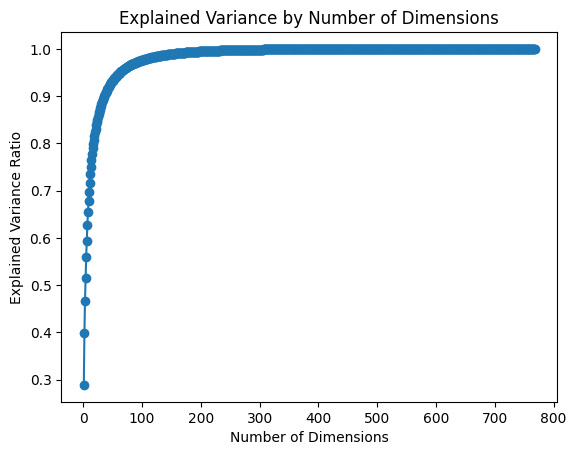

(1021, 24)

In [6]:
X = embedding_df.copy()
# Apply PCA
pca = PCA()
pca.fit(X)


# Plot explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Number of Dimensions')
plt.show()
# We reduce the dimension to avoid curse of dimensionnality

X_embeddings = PCA(0.85).fit_transform(X)
X_embeddings.shape

# Few tabular features
Let's find representative ETFs on which we all ask people to grade them.
<br>For this we need to not take to many features to escape from the curse of dimensionnality
<br>But also to have a good balance between sector break down and financial information

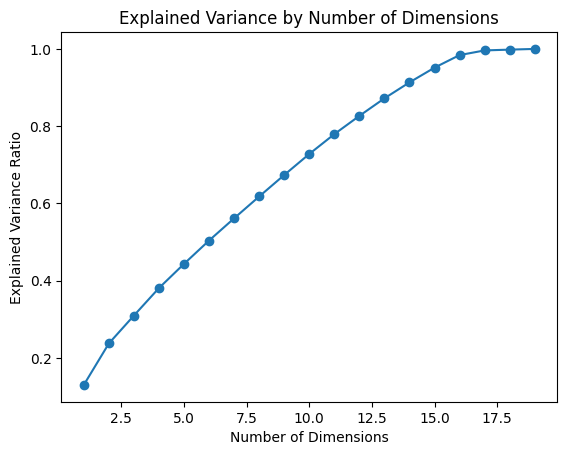

(1021, 13)

In [7]:


few_features = ['cashPosition', 'volatility', 'RSI', 'Var', 'drawdown',
                'avg_sharpe_ratio', 'beta', 'avg_monthly_return',

                'sector_realestate', 'sector_consumer_cyclical',
                'sector_basic_materials', 'sector_consumer_defensive',
                'sector_technology', 'sector_communication_services',
                'sector_financial_services', 'sector_utilities', 'sector_industrials',
                'sector_energy', 'sector_healthcare',
                ]
df_simplified = df[few_features]

std = StandardScaler()
X_std = std.fit_transform(df_simplified)

# Apply PCA
pca = PCA()
pca.fit(X_std)


# Plot explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Number of Dimensions')
plt.show()
# We reduce the dimension to avoid curse of dimensionnality
X_tabular = PCA(0.85).fit_transform(X_std)
X_tabular.shape

# Using both features

In [8]:
X = np.concatenate([X_tabular, X_embeddings], axis=1)
X.shape

(1021, 37)

# Clustering

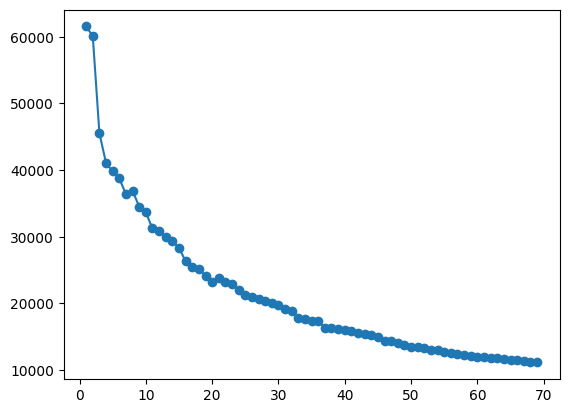

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# std = StandardScaler()
# X = std.fit_transform(df)
n_clusters_max = 70

inertia = []
for k in range(1, n_clusters_max):
    kmean = KMeans(n_clusters=k, random_state=42)
    kmean.fit(X)
    inertia.append(kmean.inertia_)

plt.plot(range(1, n_clusters_max), inertia, marker='o')

In [10]:
from sklearn.metrics import silhouette_score
# kmean = KMeans(n_clusters=15, random_state=42)
# kmean = KMeans(n_clusters=10, random_state=42)
kmean = KMeans(n_clusters=20, random_state=42)
kmean.fit(X)
label = kmean.labels_
print('silhouette score is:', silhouette_score(X, label), 'which is bad')

silhouette score is: 0.19794484456039282 which is bad


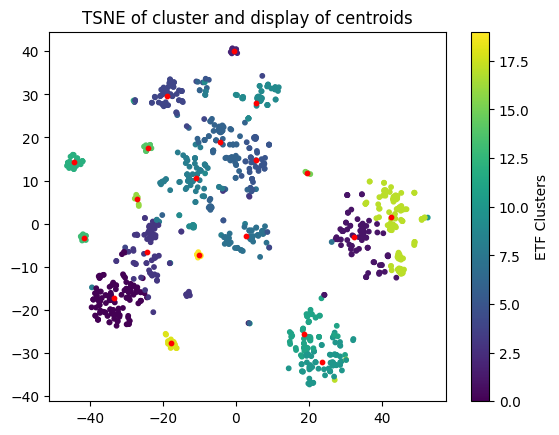

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# As we saw in the PCA these data are hard to represent well with only 2 dimensions, this partly explain the shape of the clusters
tsne = TSNE(n_components=2, random_state=15072)
temp_tsne = tsne.fit_transform(np.concatenate((X, kmean.cluster_centers_)))
X_tsne = temp_tsne[:-label.max()-1]
center = temp_tsne[-label.max()-1:]

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label, s=10)
plt.colorbar(label="ETF Clusters")
plt.scatter(center[:, 0], center[:, 1], c='r', s=10)
plt.title('TSNE of cluster and display of centroids')
plt.show()

In [12]:
# quant_traded = pd.read_csv('ETFs_by_volume.csv', index_col=0)
# quant_traded = quant_traded.reset_index(drop=True)[['ticker']].reset_index(names='ranking')
# traded_rank = pd.merge(data, quant_traded, how='left', on='ticker')['ranking']

quant_traded = pd.read_csv('ETFs_by_volume.csv', index_col=0)
quant_traded = quant_traded.merge(data[['quote', 'ticker']], how='inner', on='ticker')
quant_traded['weighted_average'] = quant_traded['volume'] * quant_traded['quote'].astype(float)
quant_traded = quant_traded.sort_values(by='weighted_average', ascending=False).reset_index(drop=True)[['ticker']].reset_index(names='ranking')
traded_rank = pd.merge(data, quant_traded, how='inner', on='ticker')['ranking']


n_label = label.max()
best_rank = []
for k in range(n_label):
    cluster_k = traded_rank[label == k]
    best = cluster_k.min()
    best_index = cluster_k.idxmin()

    best_ETF = quant_traded[quant_traded['ranking'] == best]['ticker'].iloc[0]
    best_rank.append([best, best_index, k, best_ETF])

best_rank = np.array(best_rank, dtype=object)
best_rank = pd.DataFrame(best_rank, columns=['ranking', 'index', 'cluster', 'ticker']).sort_values('ranking')
best_rank

,ranking,index,cluster,ticker
5,0,352,5,IUSZ
17,1,34,17,EUN5
9,2,756,9,EUNL
6,3,318,6,EXW1
10,12,512,10,IS0F
0,15,750,0,QDVR
11,26,515,11,SXRC
1,29,363,1,2B7M
3,30,853,3,QDVE
8,37,966,8,EXV1


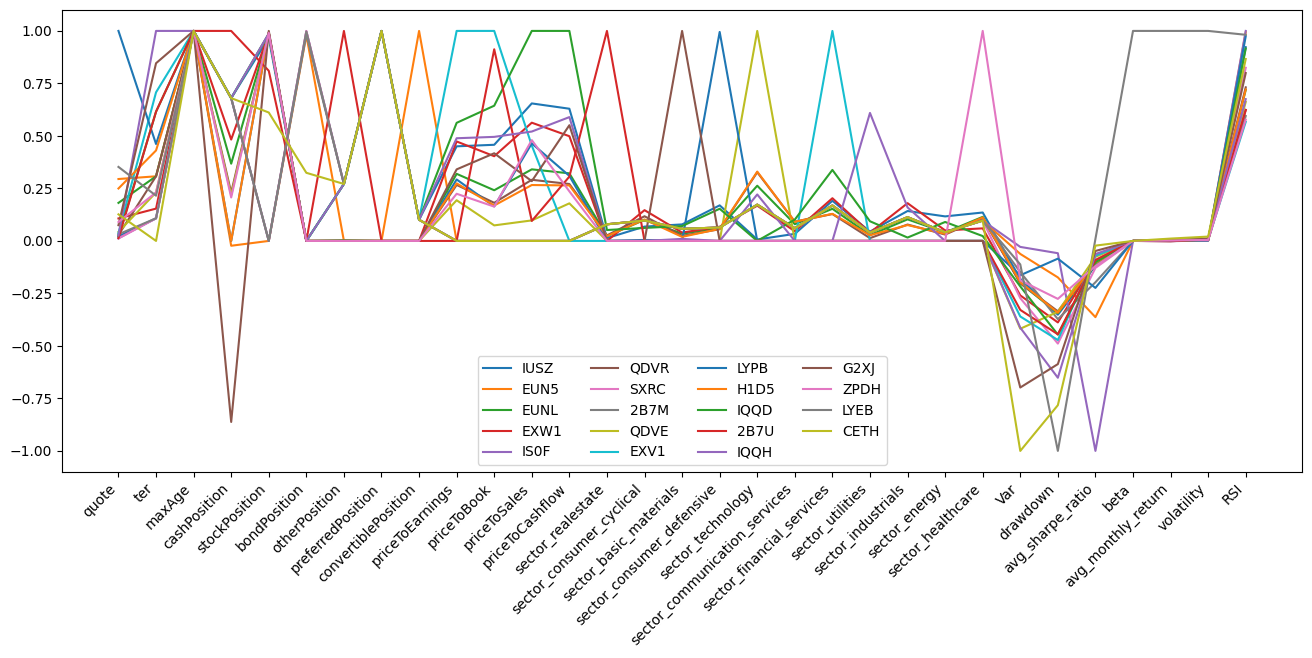

In [13]:
normalisation_term = np.abs(df.loc[best_rank['index'].astype(int)]).max(axis=0)

normalisation_term[['sector_realestate', 'sector_consumer_cyclical',
                    'sector_basic_materials', 'sector_consumer_defensive',
                    'sector_technology', 'sector_communication_services',
                    'sector_financial_services', 'sector_utilities', 'sector_industrials',
                    'sector_energy', 'sector_healthcare',]] = 1

# normalisation_term[['cashPosition', 'stockPosition', 'bondPosition', 'otherPosition',
#                     'preferredPosition', 'convertiblePosition']] = 1
normalisation_term = np.where(normalisation_term == 0, np.ones(normalisation_term.shape), normalisation_term)
plt.figure(figsize=(16, 6))
for index, ticker in best_rank[['index', 'ticker']].to_numpy():
    plt.plot(df.loc[index]/normalisation_term, label=ticker)

plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower center', ncol=4)

# Creating a synthetic user preference dataset

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
import ast
labels = np.unique(data['labels'].apply(ast.literal_eval).sum())

user_labels = np.stack([np.random.choice(labels, size=(8), replace=False) for _ in range(5000)])
# user_labels = np.stack([np.random.choice(labels, size=(25), replace=False) for _ in range(10)])
user_embeddings = pd.Series([repr(row.tolist()) for row in user_labels]).progress_apply(get_embedding)
ref_ETF = embedding_df.loc[best_rank['index'].astype(int), :]
cosine_sim_matrix = cosine_similarity(np.array(user_embeddings), ref_ETF.values)
user_ratings = (cosine_sim_matrix - cosine_sim_matrix.min(axis=1, keepdims=True)) / (cosine_sim_matrix.max(axis=1, keepdims=True) - cosine_sim_matrix.min(axis=1, keepdims=True))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
# np.save('user_rating', user_ratings)
# best_rank.to_csv('selected_ETFs.csv', index=False)

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define the model class


class Encoder(nn.Module):
    def __init__(self, user_input_size, ETF_input_size, hidden_size, feature_space_size):
        super(Encoder, self).__init__()

        # Define the layers
        self.encode_user = nn.Sequential(
            nn.Linear(user_input_size, user_input_size*2),
            nn.ReLU(),
            nn.Linear(user_input_size*2, user_input_size*2),
            nn.ReLU(),
            nn.Linear(user_input_size*2, feature_space_size)
        )

        self.encode_ETF = nn.Sequential(
            nn.Linear(ETF_input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, feature_space_size)
        )

    def forward(self, users, etfs):
        return self.encode_user(users), self.encode_ETF(etfs)


model = Encoder(user_ratings.shape[1], )